In [39]:
import numpy as np
import open3d
#from open3d import JVisualizer
from scipy.special import sph_harm
import Sph_hmade
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
def cart_to_sphe(xyz):
    """
    Converts cartesian coordinates to spherical coordinates
    """
    xy = xyz[:,0]**2 + xyz[:,1]**2
    rho = np.sqrt(xy + xyz[:,2]**2)
    phi = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    theta = np.arctan2(xyz[:,1], xyz[:,0])
    return rho,phi,theta

In [41]:
pcd    = open3d.io.read_point_cloud("example.ply")
points = np.asarray(pcd.points)
pcd    = pcd.voxel_down_sample(voxel_size=0.00001)
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)
if(colors.shape[0]==0):
    colors = np.ones(points.shape) *  [0.85, 0.7100000000000001, 0.29]

In [42]:
#save pcd as image without JVisualizer
open3d.visualization.draw_geometries([pcd], "output.png", width=1920, height=1080, point_show_normal=False)


In [43]:
points = points - points.mean(0)
rho,phi,theta = cart_to_sphe(points)

# Unit sphere visualization

We can visualize rho on the unit sphere as gray scale colors

In [44]:
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)
points2 = np.concatenate([np.expand_dims(x,1),np.expand_dims(y,1),np.expand_dims(z,1)],1)

pcd2        = open3d.geometry.PointCloud()
pcd2.points = open3d.utility.Vector3dVector(points2)
rho         = np.expand_dims(rho,1)
rho_vis     = np.concatenate([rho,rho,rho],1)
rho_vis     = (rho_vis - rho_vis.min(0))/(rho_vis.max(0)-rho_vis.min(0))
pcd2.colors = open3d.utility.Vector3dVector(rho_vis)
open3d.visualization.draw_geometries([pcd2], "output2.png", width=1920, height=1080, point_show_normal=False)

Now we can either use the entire object to get the spherical harmonics from or separate it in two. Below we select the two parts for all the theta<=0 and theta >0

We also define L which is the maximum degree for which we want to computer the harmonics 

In [45]:
idxs = [theta<=0,theta>0]
L = 10

The following function takes as an input the spherical harmonics [order,degree,coefficient], the colors which represent their sum and the polar+azimutal coordinates

In [46]:
def compute_sph(harms,colors4,theta2,phi2):
    """
    Computes spherical harmonics

    Args:
        harms: list of spherical harmonics to compute
        colors4: colors of the points
        theta2: theta values
        phi2: phi values

    Returns:
        colors4: colors of the points
    """
    for h in harms:
        fcolors = sph_harm(h[0],h[1],theta2 , phi2)
        fcolors = fcolors.real
        fcolors = np.expand_dims(fcolors,1)
        fcolors = np.concatenate([fcolors,fcolors,fcolors],1)*h[2]
        colors4 = colors4 + fcolors
    return colors4

The following function basically takes the points spherical coordinates (rho,phi,theta) and the idxs we want to use. Then it computes the forward spherical harmonics transform to obtain the coefficients. We use the coefficients to compute the reconstruction stores in colors2 and we return the spherical harmonics coefficients for the object and the reconstructed object

In [47]:
def compute_reconstruction(rho,theta,phi,idx):
        """
        Computes the reconstruction of the object
        
        Args:
            rho: rho values
            theta: theta values
            phi: phi values
            idx: index of the points
            
        Returns:
            coefs: coefficients of the spherical harmonics
            colors4: colors of the points
            points_new: new points
        """
        rho     =    rho[idx]
        theta   =  theta[idx]
        phi     =    phi[idx]
        x = np.sin(phi) * np.cos(theta)
        y = np.sin(phi) * np.sin(theta)
        z = np.cos(phi)
        points_new = np.concatenate([np.expand_dims(x,1),np.expand_dims(y,1),np.expand_dims(z,1)],1)

        colors4 = np.zeros(points_new.shape)
        
        ## We computer the forward spherical harmonics transformation to infer the coefficient for the object
        coefs = Sph_hmade.forwardSHT(L,np.array([theta,phi,rho]),True)
      
        harms = []
        for l in range(0,L+1):
            if(l==0):
                harms.append([0,0,coefs[0]])
            else:
                for m in range(0,l+1):
                    harms.append([m,l,1.0])
        for i in range(0,len(harms)):
            harms[i][2] = coefs[i]


        colors4 =  compute_sph(harms,colors4,theta,phi)
        
        return np.abs(coefs),colors4,points_new

In [48]:
coefs            = []
col4             = []
reordered_pts    = []
reordered_colors = []
for i in idxs:
        coef,colors4,points_new=compute_reconstruction(rho[:,0],theta,phi,i)
        print("number of coefficients computed for this part : ",coef.shape)
        col4.append(colors4)
        coefs.append(coef)
        reordered_pts.append   (points_new)
        reordered_colors.append(colors[i,:])
        
col4 = np.concatenate(col4)
reordered_pts = np.concatenate(reordered_pts)
reordered_colors = np.concatenate(reordered_colors)

number of coefficients computed for this part :  (66,)
number of coefficients computed for this part :  (66,)


We can now show the original object (left), unit sphere projected (center) and the one reconstructed using the computed spherical harmonics coefficients (right)

In [49]:
### unit pts
pcd4 = open3d.geometry.PointCloud()
pcd4.points = open3d.utility.Vector3dVector(reordered_pts+np.array([1.5,0,0]))
pcd4.colors = open3d.utility.Vector3dVector(reordered_colors)
##reconstruction
pcd5 = open3d.geometry.PointCloud()
pcd5.points = open3d.utility.Vector3dVector((reordered_pts*col4)+np.array([3,0,0]))
pcd5.colors = open3d.utility.Vector3dVector(reordered_colors)
open3d.visualization.draw_geometries([pcd,pcd4,pcd5], "output3.png", width=1920, height=1080, point_show_normal=False)

Let's now show the coefficient we computed which we used to reconstruct our object

In [50]:
coefs = np.array(coefs)
length = coefs.shape[1]
coefs_reshaped = np.reshape(np.array(coefs),(coefs.shape[0]*coefs.shape[1]))

<BarContainer object of 132 artists>

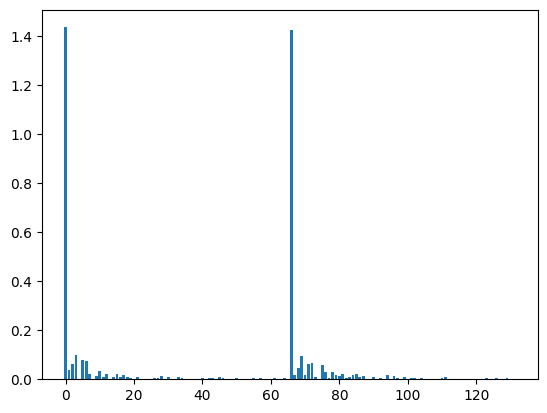

In [51]:
plt.bar(np.arange(0,coefs_reshaped.shape[0],1),coefs_reshaped)

In [52]:
plt.show()